<a href="https://colab.research.google.com/github/rara-by/Practice-Notebooks/blob/main/Sharara_S24_AISec_Lab4_IDS_v2_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection in Network Traffic with K-means clustering**
We can categorize machine learning algorithms into two main groups: supervised learning and unsupervised learning. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called clusters. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful tutorial.

# Goals
We expect students to:
* Learn (or review) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

# Steps
1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# **1. K-means**
# **1.1. Introduction**
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of  k , it tries to build  k  clusters from samples in the dataset. Therefore,  k  is an hyperparameter of the model. The right value of  k  is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a  d -dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by SKLearn.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a  d -dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

# **1.2. How does it work ?**
Given  k , the K-means algorithm works as follows:

1. Randomly choose  k  data points (seeds) to be the initial centroids
2. Assign each data point to the closest centroid
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result. From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

# **1.3. Illustrative example**
One of the best ways to study an algorithm is trying implement it. In this section, we will go step by step to implement a simple K-means algorithm.

Use the below function to calculate an euclidean distance between any two points in  d -dimensional data space.

In [70]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(c1 - c2)**2 for c1, c2 in zip(p1, p2)]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

Given a data point and the current set of centroids, use the function below to find the index of the closest centroid for that data point.

In [71]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    return min(enumerate(centroids), key=lambda x: euclidean_distance(datapoint, x[1]))[0]

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

Use the function below to randomize  k  initial centroids.

In [72]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    random_indices = np.arange(len(data))
    np.random.shuffle(random_indices)
    random_indices = random_indices[:k]
    centroids = [data[i] for i in range(len(data)) if i in random_indices]
    return centroids

assert(len(
    randomize_centroids(
        np.array([
            np.array([2,1,2]),
            np.array([1,2,1]),
            np.array([3,1,2])
             ]),
        2)) == 2), "Wrong function"

Use function check_converge to check the stop creteria of the algorithm.

In [73]:
MAX_ITERATIONS = 10

# return True if clusters have converged , otherwise, return False
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    distances = np.array([euclidean_distance(c, o) for c, o in zip(centroids, old_centroids)])
    if (distances <= threshold).all():
        return True
    return False

Use function update_centroid to update the new positions for the current centroids based on the position of their members.

In [74]:
def update_centroids(centroids, clusters):
    new_centroids = []
    for cluster in clusters:
        # Only update centroids for non-empty clusters
        if len(cluster) > 0:
            # Convert cluster to a NumPy array for easy mean calculation
            cluster_np = np.array(cluster)
            # Calculate the mean along the columns to find the new centroid
            new_centroid = cluster_np.mean(axis=0)
            new_centroids.append(new_centroid)
        else:
            # For empty clusters, we can choose a strategy such as leaving the centroid as is
            new_centroids.append(None)  # Or handle appropriately
    # Filter out None values if any empty clusters were left as None
    new_centroids = [centroid for centroid in new_centroids if centroid is not None]
    return new_centroids


Use the K-means algorithm skeleton below, with the functions you wrote above.

In [75]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):

    data = np.array(data)
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)

            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)

        # keep the current position of centroids before changing them
        old_centroids = centroids[:]

        # update centroids
        centroids = update_centroids(centroids, clusters)

        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break

    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

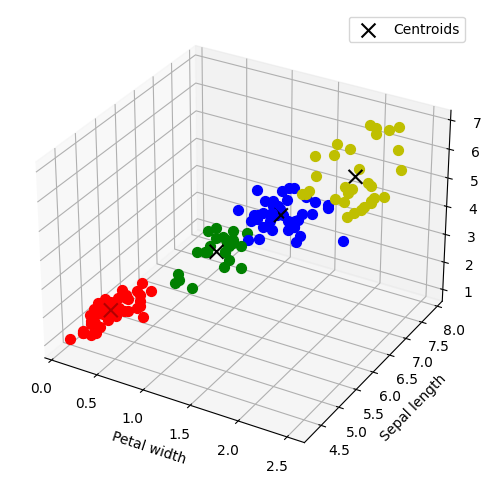

In [76]:
%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=4)
labels = [find_closest_centroid(p, centers) for p in X_iris]

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Set the colors for each cluster
colors = ['r', 'g', 'b', 'y']  # Assuming up to 4 clusters for simplicity

# Plot each data point in the 3D plot
for i in range(len(X_iris)):
    ax.scatter(X_iris[i, 3], X_iris[i, 0], X_iris[i, 2], c=colors[labels[i]], s=50)

# Plot the centroids
centroids = np.array(centers)  # Ensure centroids are in a NumPy array for easy indexing
if centroids.size:  # Check if centroids are not empty
    ax.scatter(centroids[:, 3], centroids[:, 0], centroids[:, 2], c='black', s=100, marker='x', label='Centroids')

# Set labels for the axes
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

# Legend
ax.legend()

plt.show()


# **2. Usecase: Network Intrusion**
Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

# **2.1. Data**
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as su_attempted in the 15th column. Some features are counts, like num_file_creations in the 17th columns. Some others are the number of sent and received bytes.

# **2.2. Clustering without using categorical features**
First, we need to import some packages that are used in this notebook.

In [77]:
import pandas as pd

Let's create a list of all the features (think column names) of data in KDD99. This information is presented in the dataset description [here](https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names).

In [78]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'intrusion_type']

In [79]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz -O kddcup.data_10_percent_corrected.gz
!gzip -d kddcup.data_10_percent_corrected.gz


--2024-02-26 02:39:59--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent_corrected.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  2.22MB/s    in 0.9s    

2024-02-26 02:40:00 (2.22 MB/s) - ‘kddcup.data_10_percent_corrected.gz’ saved [2144903/2144903]

gzip: kddcup.data_10_percent_corrected already exists; do you wish to overwrite (y or n)? n
	not overwritten


Now, let's load the data into a Pandas dataframe.

In [80]:
data = pd.read_csv('kddcup.data_10_percent_corrected', names=features, header=None)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


Now that the dataset is loaded, we can explore the composition of the data:

In [81]:
print('The no of data points are:',data.shape[0])
print('='*40)
print('The no of features are:',data.shape[1])
print('='*40)

The no of data points are: 494021
The no of features are: 42


Enumerate the labels (i.e., attack types + normal)

In [82]:
output = data['intrusion_type'].values
labels = set(output)
print('The different type of output labels are:',labels)
print('='*100)
print('No. of different output labels are:', len(labels))

The different type of output labels are: {'guess_passwd.', 'normal.', 'phf.', 'neptune.', 'smurf.', 'warezclient.', 'warezmaster.', 'satan.', 'multihop.', 'imap.', 'pod.', 'loadmodule.', 'perl.', 'spy.', 'rootkit.', 'buffer_overflow.', 'back.', 'teardrop.', 'land.', 'ipsweep.', 'ftp_write.', 'portsweep.', 'nmap.'}
No. of different output labels are: 23



# **2.2.1. Loading data**
There are two types of features: numerical features and categorical features. Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1:** we don't use the labels in the training phase !!!

**Note 2:** in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

# **Question 1 - Data Cleaning**
Pre-process the data and remove:
* Incomplete Data points (i.e., those with null values)
* Duplicate data points (i.e., repeated data points)

Use native Pandas functions to implement this step.

In [83]:
##########
## Your code here
##########
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
data.drop_duplicates(inplace=True)
# dup = data.duplicated()
# # print(dup)
# for idx, val  in enumerate(dup):
#   if val:
#     print(idx)
#printing the shape of the preprocessed data.
data.shape

(494021, 42)
(494021, 42)


(145586, 42)

# **Question 2**
Using K-means algorithm of SKLearn, cluster the connections (i.e., data points) into two groups then plot the result. In this step, only consider the numerical features, and disregard caregorical features.

Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* maxIterations=10
* n_init=10 or init='random'

Discuss the result from your figure.

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145586 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145586 non-null  int64  
 1   protocol_type                145586 non-null  object 
 2   service                      145586 non-null  object 
 3   flag                         145586 non-null  object 
 4   src_bytes                    145586 non-null  int64  
 5   dst_bytes                    145586 non-null  int64  
 6   land                         145586 non-null  int64  
 7   wrong_fragment               145586 non-null  int64  
 8   urgent                       145586 non-null  int64  
 9   hot                          145586 non-null  int64  
 10  num_failed_logins            145586 non-null  int64  
 11  logged_in                    145586 non-null  int64  
 12  num_compromised              145586 non-null  int64  
 13 

In [85]:
from sklearn.cluster import KMeans
import numpy as np

##########
## Your code here
##########

# Only use numerical features
numerical_features = data.select_dtypes(exclude=['object'])### complete this list
print(numerical_features.shape)
# Create a KMeans object with 2 clusters
km = KMeans(n_clusters=2, max_iter=10, init='random')

# Fit the model to the data
km.fit(numerical_features)

# Print the size of each cluster
print('Cluster sizes:', km.labels_.shape)



(145586, 38)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster sizes: (145586,)


In [64]:
km.n_iter_

5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


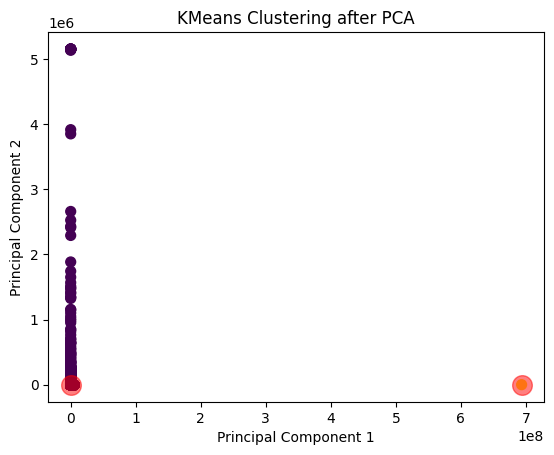

In [108]:
#using PCA to plot the data into 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(numerical_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, max_iter=10, init='random')
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering after PCA')
plt.show()

The data is clustered into one group. Some outliers can be seen which may have caused the skewing of the clusters.

# **Question 3**
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Use the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs. What do you think about the result ?

In [62]:
cluster_labels = pd.DataFrame(list(zip(km.labels_, data['intrusion_type'])), columns=['cluster', 'label'])
print(cluster_labels.groupby(['cluster', 'label']).size().unstack().fillna(0))


label    back.  buffer_overflow.  ftp_write.  guess_passwd.  imap.  ipsweep.  \
cluster                                                                        
0        968.0              30.0         8.0           53.0   12.0     651.0   
1          0.0               0.0         0.0            0.0    0.0       0.0   

label    land.  loadmodule.  multihop.  neptune.  ...  phf.   pod.  \
cluster                                           ...                
0         19.0          9.0        7.0   51820.0  ...   4.0  206.0   
1          0.0          0.0        0.0       0.0  ...   0.0    0.0   

label    portsweep.  rootkit.  satan.  smurf.  spy.  teardrop.  warezclient.  \
cluster                                                                        
0             415.0      10.0   906.0   641.0   2.0      918.0         893.0   
1               1.0       0.0     0.0     0.0   0.0        0.0           0.0   

label    warezmaster.  
cluster                
0                20.0  
1    

**Write your comments here (graded)**

The model converged after 5 iterations and resulted in a single cluster. The data may not have clear clusters. Normalizing the data might fix this.

The clusters could not be plotted as the datapoints have 38 features.

# **2.2.4. Choosing K**
How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of  k . For doing that, we have to build and evaluate models with different values of  k . A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

# **Question 4**
Use the function below to calculate the MSE of each model that is corresponding to each value of  k . Plot the results. From the obtained result, what is the best value for  k  ? Why ?

k =   5, SSSE = 88765049563962
k =  25, SSSE = 965354512275
k =  45, SSSE = 235773338771
k =  65, SSSE = 95877084756
k =  85, SSSE = 52400554911
k = 105, SSSE = 32830268368
k = 125, SSSE = 21491865213


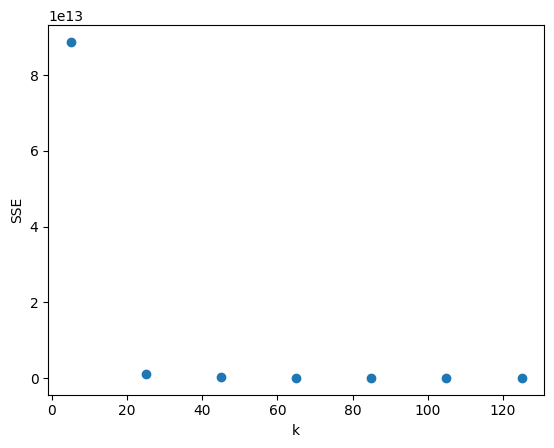

In [86]:
from sklearn.cluster import KMeans

# Define the range of k values to test
k_range = range(5, 126, 20)

# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(numerical_features)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


**Write your comments here (graded)**

 SSE represents the sum of squared distances of samples to their closest cluster center. It quantifies the variability within the clusters. Lower values indicate that the clusters are dense and well-separated. Here we can see the value of SSE decreased with more clusters. The best value we get is k = 125.

# **2.2.5 Normalizing features**
K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias.

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation
\begin{align}
normalize_i=\frac{feature_i - \mu_i}{\sigma_i}
\end{align}
Where,
* $normalize_i$  is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$

# **Question 5**
Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i=0$ then ${normalize}_i = {feature}_i−\mu_i$

In [100]:
def normalize_data(data):
  """
  Normalizes the data by converting each feature to a standard score.

  Args:
    data: A Pandas DataFrame containing the data to be normalized.

  Returns:
    A Pandas DataFrame containing the normalized data.
  """

  ############
  ## Your Code Here##
  #############
  normalized_data = (data - data.mean()) / data.std()
  return normalized_data

normalized_data = normalize_data(numerical_features)
print(normalized_data.head())


   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0  -0.10785  -0.004293   0.042595 -0.011722       -0.084394 -0.004737   
1  -0.10785  -0.004261  -0.039036 -0.011722       -0.084394 -0.004737   
2  -0.10785  -0.004263  -0.025042 -0.011722       -0.084394 -0.004737   
3  -0.10785  -0.004272  -0.025042 -0.011722       -0.084394 -0.004737   
4  -0.10785  -0.004273  -0.013613 -0.011722       -0.084394 -0.004737   

        hot  num_failed_logins  logged_in  num_compromised  ...  \
0 -0.070209          -0.018022   1.017165        -0.007905  ...   
1 -0.070209          -0.018022   1.017165        -0.007905  ...   
2 -0.070209          -0.018022   1.017165        -0.007905  ...   
3 -0.070209          -0.018022   1.017165        -0.007905  ...   
4 -0.070209          -0.018022   1.017165        -0.007905  ...   

   dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
0       -1.740377           -1.054220                0.979268   
1       -1.639467           

# **Question 6**
Using the new data, build different models with different values of $k\in [60,70,80,90,100,110]$ . Evaluate the results by plotting them and choose the best value of $k$.

In [101]:
print(normalized_data.shape)

(145586, 38)


k =  60, SSSE = 256915
k =  70, SSSE = 222319
k =  80, SSSE = 193835
k =  90, SSSE = 173774
k = 100, SSSE = 152714
k = 110, SSSE = 139120


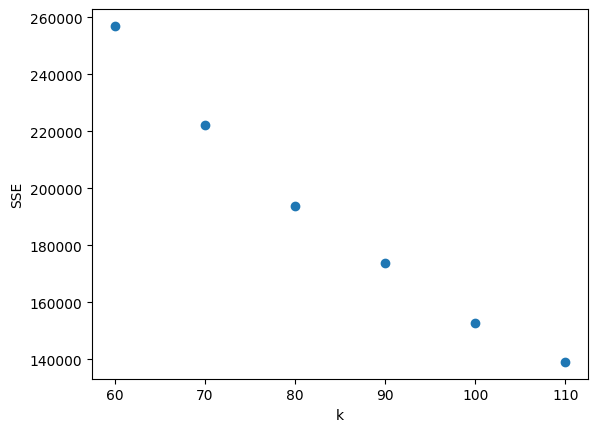

In [106]:
# Your code
normalized_data.drop(columns=['num_outbound_cmds', 'is_host_login' ], inplace=True)
# Define the range of k values to test
k_range = [60,70,80,90,100,110]

# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(normalized_data)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


In [105]:
normalized_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145586 entries, 0 to 494020
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145586 non-null  float64
 1   src_bytes                    145586 non-null  float64
 2   dst_bytes                    145586 non-null  float64
 3   land                         145586 non-null  float64
 4   wrong_fragment               145586 non-null  float64
 5   urgent                       145586 non-null  float64
 6   hot                          145586 non-null  float64
 7   num_failed_logins            145586 non-null  float64
 8   logged_in                    145586 non-null  float64
 9   num_compromised              145586 non-null  float64
 10  root_shell                   145586 non-null  float64
 11  su_attempted                 145586 non-null  float64
 12  num_root                     145586 non-null  float64
 13 

Your comments

Normalization led to some incompatible values in two columns (num_outbound_cmds,is_host_login) which caused a ValueError for the SKlearn K-Means estimator. Dropping these two columns solved the problem.

Normalizing the dataset brought down the SSE values significantly which is a good sign. The best value is acheived for k = 110.

# **Question 7**
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


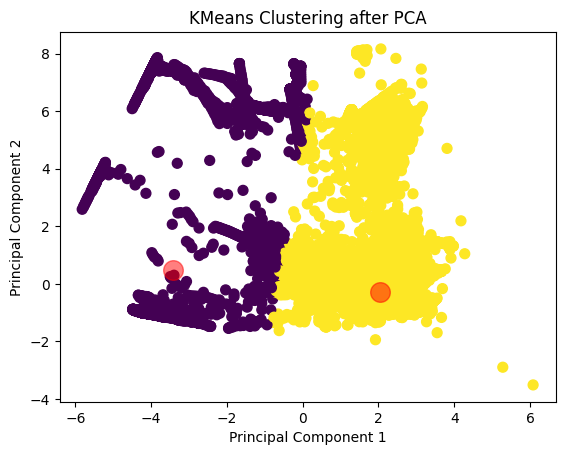

In [109]:
#using PCA to plot the data into 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(normalized_data)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, max_iter=10, init='random')
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering after PCA')
plt.show()

**Write your comments here (graded)**

The data is now divided into two clusters but the clusters are quite close by to each other. It is because normalizing eliminates the effect of the previously seen outliers

# **2.3. Clustering using categorical features**
# **2.3.1 Loading data**
In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering. The problem is that K-means (or at least, the one we have developed and the one we use from SKLearn) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in  d -dimensional vectors, and a nice way to do it is to use [word2vec](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/). If you're interested, follow this link to a nice blog post on the problem.

There are two approaches:

* **Approach 1:** mapping one categorial feature to one numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* Approach 2: mapping mapping one categorial feature to multiple numerical features. Basically, a single variable with  n  observations and  d  distinct values, to  d  binary variables with  n  observations each. Each observation indicating the presence (1) or absence (0) of the  dth  binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes
\begin{align}
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
\end{align}
We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.

# **Question 8**
Calculate the number of distinct categorical features value (at index 1,2,3). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

In [122]:
categorical_columns = [1, 2, 3]
categorical_features = data.iloc[:, categorical_columns]

# Calculate the number of distinct values for each categorical feature
distinct_values = categorical_features.nunique()
print(distinct_values)

# Perform one-hot encoding on categorical features
one_hot_encoded_df = pd.get_dummies(categorical_features)

# Concatenate one-hot encoded features with numerical features
data_copy = data[:]
data_cat = pd.concat([normalized_data, one_hot_encoded_df], axis=1)
data_cat

protocol_type     3
service          66
flag             11
dtype: int64


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.10785,-0.004293,0.042595,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004261,-0.039036,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004263,-0.025042,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004272,-0.025042,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013613,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,-0.10785,-0.004222,-0.016096,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
494017,-0.10785,-0.004237,-0.009436,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
494018,-0.10785,-0.004281,-0.027295,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0
494019,-0.10785,-0.004232,-0.027295,-0.011722,-0.084394,-0.004737,-0.070209,-0.018022,1.017165,-0.007905,...,0,0,0,0,0,0,0,0,1,0


# **2.3.2. Building models**
# **Question 9**
Using the new data, cluster the connections with different values of $k\in [80,90,100,110,120,130,140,150,160]$. Evaluate the results and choose the best value of  k  as previous questions.

In [ ]:
datatypes = list(data_cat.dtypes)
datatypes

k =  80, SSSE = 222291
k =  90, SSSE = 200807
k = 100, SSSE = 178766
k = 110, SSSE = 162243
k = 120, SSSE = 151834
k = 130, SSSE = 142065
k = 140, SSSE = 131235
k = 150, SSSE = 125829
k = 160, SSSE = 117381


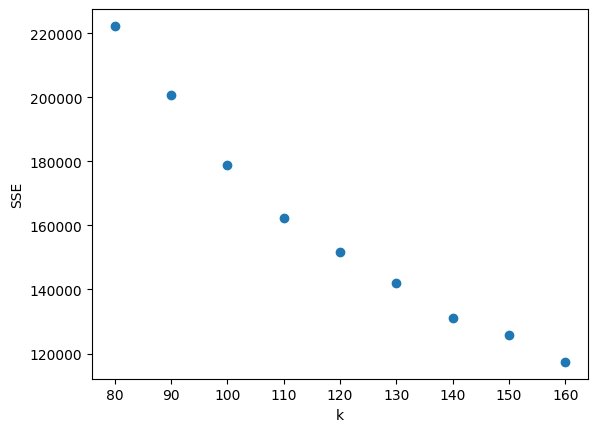

In [125]:
k_range = [80,90,100,110,120,130,140,150,160]
# data_cat = data_cat.select_dtypes(exclude=['O'])
# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(data_cat)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


Your comments

The best value of k is 160. Further testing would likely have gotten us even better SSE.



# **2.4. Anomaly detection**
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

# **Question 10**
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [ ]:
#Your code
from scipy.spatial.distance import cdist

kmeans_model = KMeans(n_clusters=160, max_iter=10, n_init=10)
kmeans_model.fit(data_cat)

In [142]:
print(data_cat.shape, kmeans_model.cluster_centers_.shape)

(145586, 116) (160, 116)


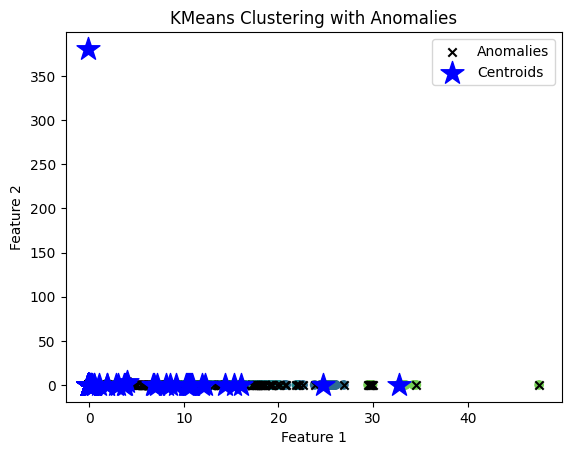

In [146]:
distances = np.min(cdist(data_cat, kmeans_model.cluster_centers_, 'euclidean'), axis=1)
threshold = np.percentile(distances, 99) # 99th percentile as the threshold

anomalies = data_cat[distances > threshold]

plt.scatter(data_cat.iloc[:, 0], data_cat.iloc[:, 1], c=kmeans_model.labels_, cmap='viridis')
plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1], color='black', marker='x', label='Anomalies')
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s=300, c='blue', marker='*', label='Centroids')
plt.legend()
plt.title('KMeans Clustering with Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


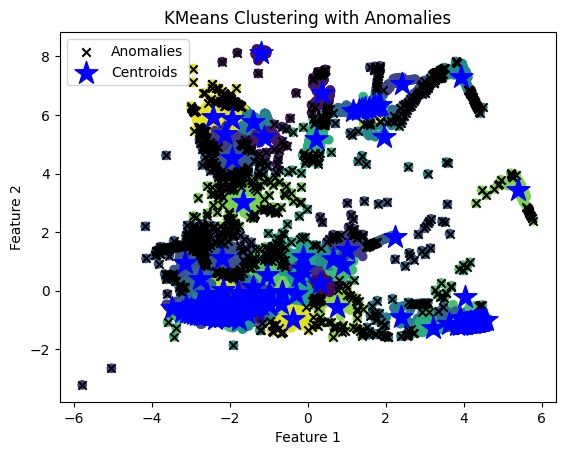

In [150]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_cat)

# Apply KMeans clustering
# kmeans = KMeans(n_clusters=160, max_iter=10, init='random')
kmeans.fit(X_pca)

distances = np.min(cdist(X_pca, kmeans.cluster_centers_, 'euclidean'), axis=1)
threshold = np.percentile(distances, 99) # 99th percentile as the threshold

anomalies = X_pca[distances > threshold]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='black', marker='x', label='Anomalies')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='blue', marker='*', label='Centroids')
plt.legend()
plt.title('KMeans Clustering with Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

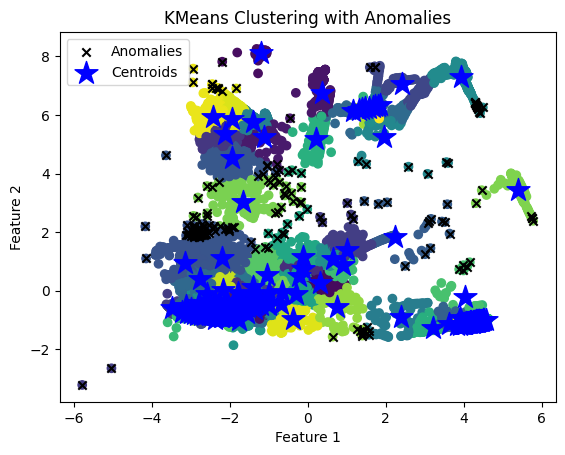

In [154]:
threshold = 0.9
anomalies = X_pca[distances > threshold]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='black', marker='x', label='Anomalies')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='blue', marker='*', label='Centroids')
plt.legend()
plt.title('KMeans Clustering with Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Your comments

The clusters are quite densely packed so picking the 99th percentile distance as the threshold still gives a lot of anomalies. Manually selecting the threshold gives a better result but still does not look right from looking at the plot.